##Step 1: Import libraries and dataset

In [1]:

import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns 
import matplotlib.pyplot as plt 

In [2]:
url = 'https://raw.githubusercontent.com/dsnqHuy/bitcoin_price_prediction/main/data/btc_365.csv'
df = pd.read_csv(url)

In [3]:
df.head()

,date,open,high,low,close
0,2021-10-30,62253.70,62359.25,60673.00,61859.19
1,2021-10-31,61859.19,62405.30,59945.36,61299.80
2,2021-11-01,61299.81,62437.74,59405.00,60911.11
3,2021-11-02,60911.12,64270.00,60624.68,63219.99
4,2021-11-03,63220.57,63500.00,60382.76,62896.48


In [4]:
df.dtypes

date      object
open     float64
high     float64
low      float64
close    float64
dtype: object

In [5]:
df['date'] = pd.to_datetime(df['date'])

##Step 2: Visualization

Text(0.5, 1.0, 'close histogram')

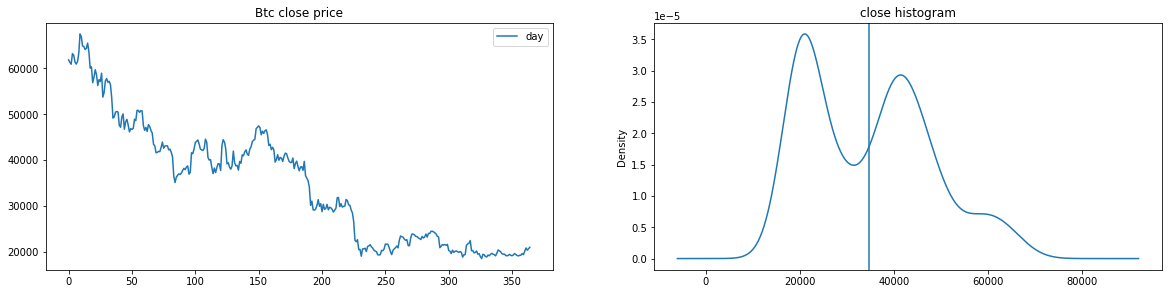

In [6]:
fig = plt.figure(figsize = (20, 10))

plt.subplot(221)
plt.plot(df['close'], '-', label = 'day')
plt.title('Btc close price')
plt.legend();

plt.subplot(222)
df['close'].plot(kind = 'kde')
plt.axvline(df['close'].mean())
plt.title('close histogram')

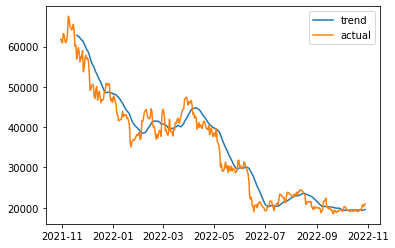

In [7]:
#See the trend of the data
plt.plot(df['date'], df['close'].rolling(20).mean(), label= 'trend')
plt.plot(df['date'], df['close'], label= 'actual')
plt.legend()

##Step 3: Normalizing

In [10]:
df_close = df['close']
df_close.shape

(365,)

In [18]:
scaler = MinMaxScaler(feature_range = (0, 1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1, 1))
print(df_close[0], "\n", df_close.shape)

[0.88450624] 
 (365, 1)


In [30]:
train_size = int(df['close'].shape[0] * 0.7)
test_size = int(df['close'].shape[0] - train_size)
train_data, test_data = df_close[0:train_size, :], df_close[train_size:len(df_close),]
print(train_data.shape, test_data.shape)

(255, 1) (110, 1)


In [32]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [44]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print(X_train[0, :])
print(X_train[-1, :])
# print("X_train: ", X_train.shape)
# print("y_train: ", y_train.shape)
# print("X_test: ", X_test.shape)
# print("y_test", y_test.shape)

[0.88450624 0.87310512 0.86518309 0.91224118 0.90564761 0.87504563
 0.86571321 0.87658646 0.91333362 1.         0.98821612 0.94612395
 0.9439193  0.93063005 0.93588375]
[0.06175202 0.05251682 0.04649393 0.03709263 0.03386667 0.03018172
 0.01668091 0.01613082 0.01741525 0.03618402 0.03494321 0.04286503
 0.06447884 0.06386271 0.0638032 ]


##Step 4: Modeling

In [35]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train, verbose=False)

[10:08:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

In [41]:
predictions = model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.02685295861082537
Root Mean squared Error - RMSE : 0.03348471222476717
